In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
# from pybiomart import Server
import scipy.sparse

In [2]:
!pip install scanpy matplotlib numpy pandas pybiomart leidenalg scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


# Normalization and HVG Selection


## Normalization of the individual batches

In [4]:
arg_doublet = sc.read("/kaggle/input/mini-project-qced-data/arg_qc.h5ad")
pb1_doublet = sc.read("/kaggle/input/mini-project-qced-data/pb1_qc.h5ad")
pb2_doublet = sc.read("/kaggle/input/mini-project-qced-data/pb2_qc.h5ad")


In [5]:
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import TruncatedSVD

def scran_normalization(adata, min_count=0.1, n_pcs=50, n_hvg=2000):
    """scran-style normalization workflow after doublet removal"""
    
    # 1. Gene filtering (similar to scran::computeSumFactors)
    if 'highly_variable' not in adata.var:
        sc.pp.filter_genes(adata, min_counts=1)
        gene_means = np.array(adata.X.mean(axis=0)).flatten()
        adata = adata[:, gene_means > min_count].copy()
    
    # 2. Per-sample clustering (if sample column exists)
    if 'sample' in adata.obs:
        clusters = []
        for sample in adata.obs['sample'].unique():
            sample_adata = adata[adata.obs['sample'] == sample].copy()
            
            # Cluster using PCA-based approach
            sc.pp.pca(sample_adata, n_comps=min(n_pcs, sample_adata.n_obs-1))
            sc.pp.neighbors(sample_adata)
            sc.tl.leiden(sample_adata, key_added='cluster')
            
            clusters.extend(sample_adata.obs['cluster'].astype(str) + f"_{sample}")
        adata.obs['cluster'] = clusters
    else:
        # Fallback: whole-dataset clustering
        sc.pp.pca(adata, n_comps=min(n_pcs, adata.n_obs-1))
        sc.pp.neighbors(adata)
        sc.tl.leiden(adata, key_added='cluster')
    
    # 3. Size factor estimation via pooling
    def compute_size_factors(counts, clusters):
        """Python implementation of scran's pooling approach"""
        cluster_means = []
        for cluster in np.unique(clusters):
            cluster_counts = counts[clusters == cluster]
            if issparse(cluster_counts):
                cluster_counts = cluster_counts.A
            # Geometric mean with pseudocount
            pseudocount = 1
            log_means = np.log(cluster_counts + pseudocount).mean(axis=0)
            cluster_means.append(np.exp(log_means))
        
        reference = np.median(cluster_means, axis=0)
        raw_sf = counts.sum(1) / np.median(counts.sum(1))
        size_factors = raw_sf * (np.median(reference) / reference.mean())
        return size_factors / np.median(size_factors)
    
    adata.obs['size_factors'] = compute_size_factors(adata.X, adata.obs['cluster'])
    
    # 4. Apply normalization
    adata.layers["normalized"] = adata.X / adata.obs['size_factors'].values[:, None]
    sc.pp.log1p(adata, layer='normalized')
    
    return adata

 
arg_norm = scran_normalization(arg_doublet)
pb1_norm = scran_normalization(pb1_doublet)
pb2_norm = scran_normalization(pb2_doublet)



2025-04-26 14:28:34.697134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745677714.878654      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745677714.930978      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_31/2187538836.py:24: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(sample_adata, key_added='cluster')


## UMI vs Size Factor Plot

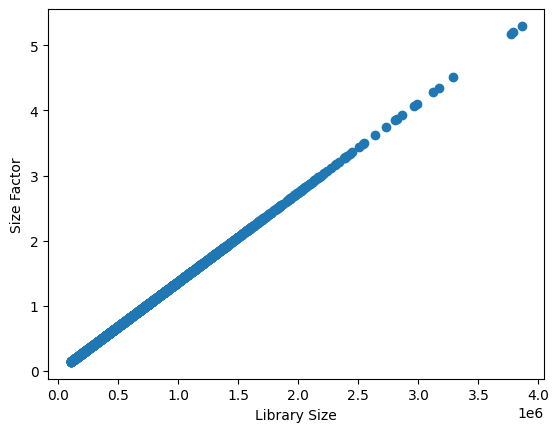

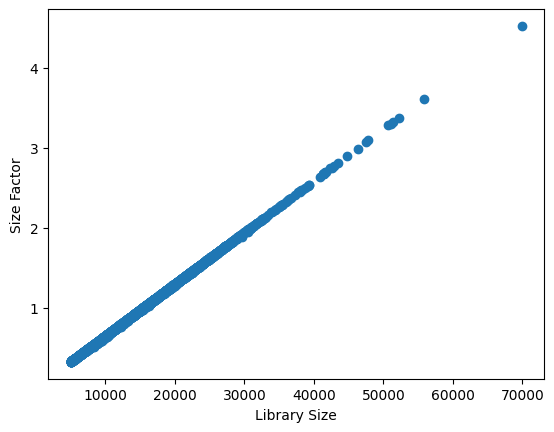

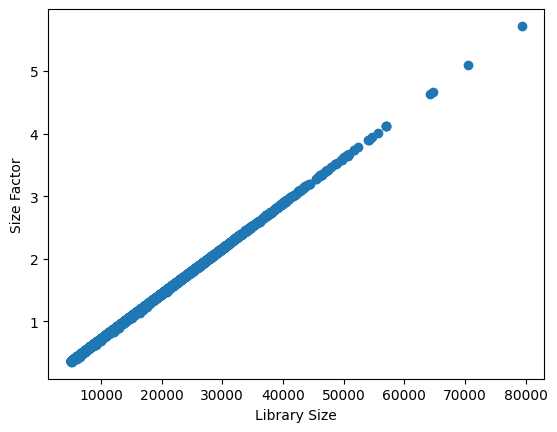

In [6]:
def plot_umi_vs_sf(adata):
    plt.scatter(adata.obs['total_counts'], adata.obs['size_factors'])
    plt.xlabel('Library Size')
    plt.ylabel('Size Factor')
    
    plt.show()


plot_umi_vs_sf(arg_norm)
plot_umi_vs_sf(pb1_norm)
plot_umi_vs_sf(pb2_norm)


## Selecting Highly Variable Genes

In [8]:
def hvgs(adata):
    
    sc.pp.highly_variable_genes(
        adata, 
        layer='normalized',
        n_top_genes=2000,
        flavor='seurat_v3'  # Matches Pijuan-Sala's approach
    )
    
    adata_hvg = adata[:, adata.var.highly_variable].copy()
    
    return adata_hvg

In [9]:
arg_hvg = hvgs(arg_norm)
pb1_hvg = hvgs(pb1_norm)
pb2_hvg = hvgs(pb2_norm)


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


## Dimensionality Reduction

In [10]:
def dim_red(adata):
# Neighbors graph
    
   # PCA
    sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
    
    # Compute neighborhood graph
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=15)
    
    # UMAP
    sc.tl.umap(adata)
    


dim_red(arg_hvg)
dim_red(pb1_hvg) 
dim_red(pb2_hvg) 


## Plots for Each Batch by Stage

... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical


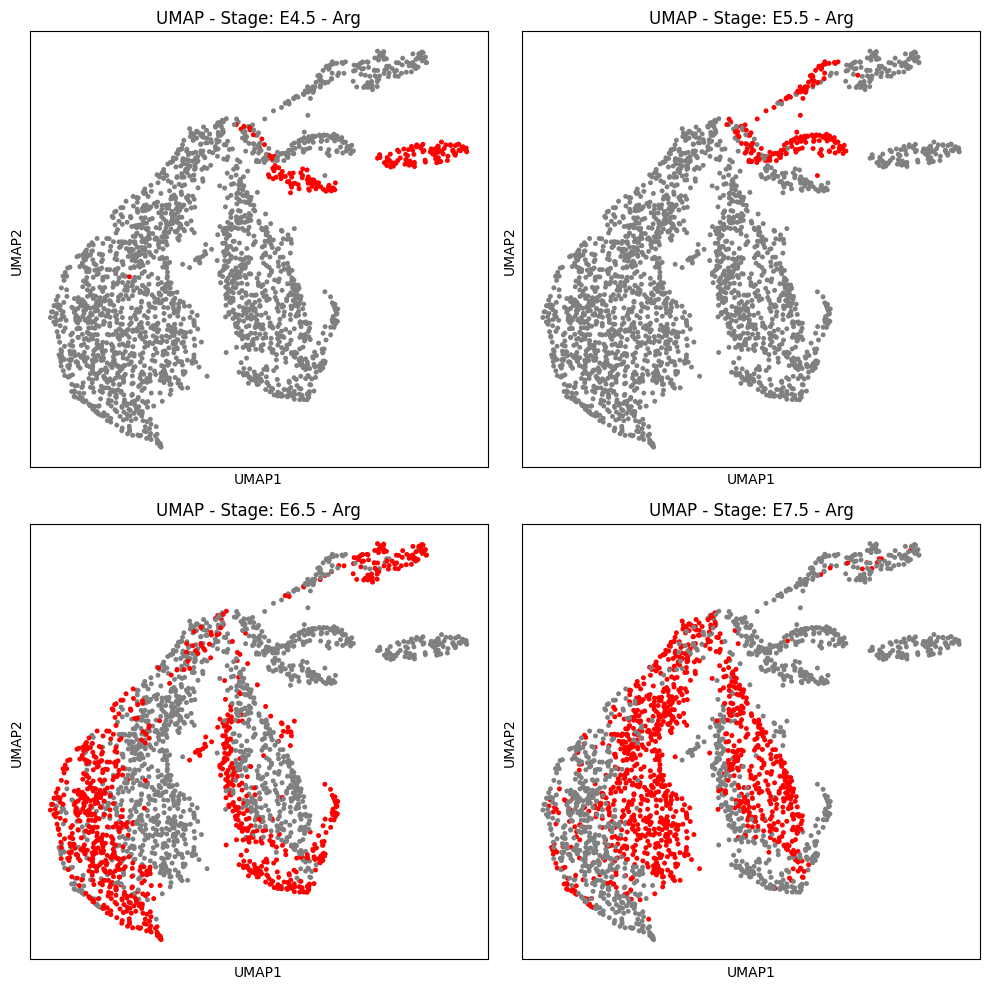

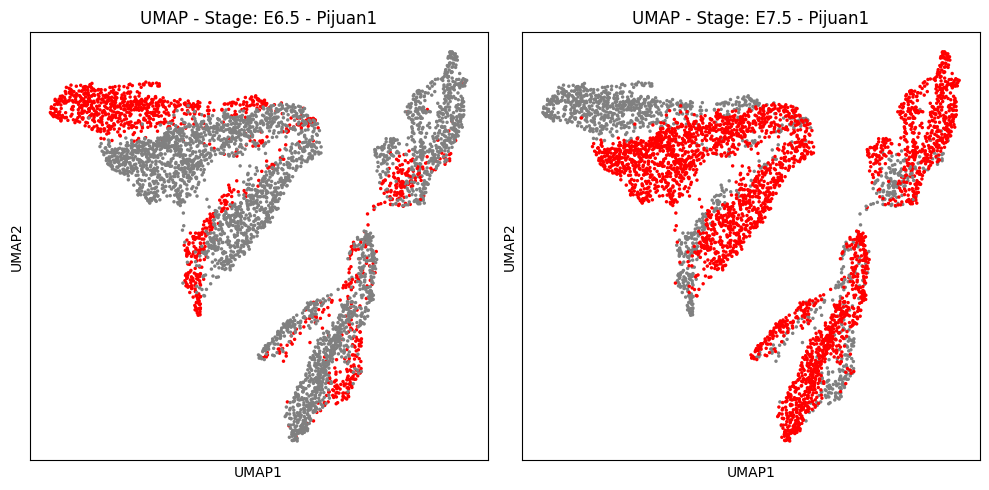

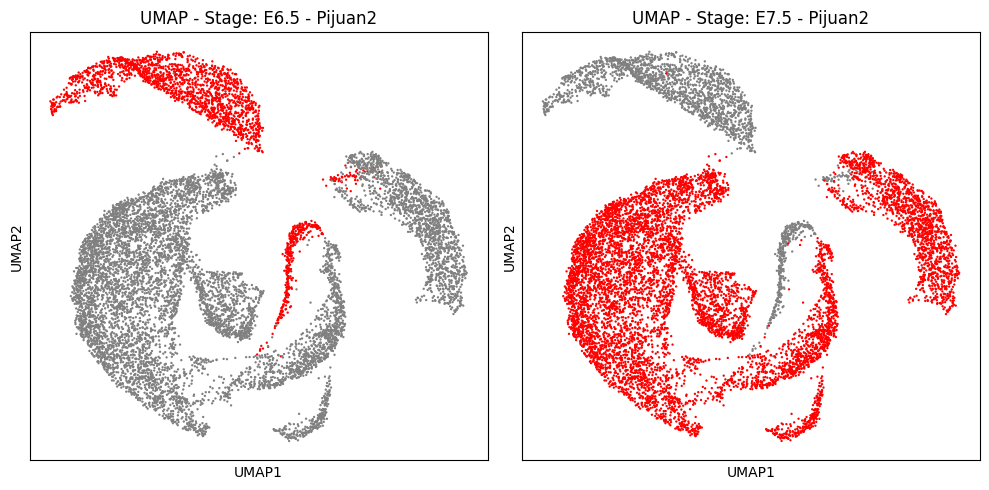

In [19]:
def sample_from_each_dev_stage(data,title):
  # Get the list of stages to be plotted (dynamically based on data)
  stages_to_plot = sorted(data.obs["stage"].unique())

  # Calculate the number of rows and columns needed to display the stages
  n_stages = len(stages_to_plot)
  n_cols = 2  # Display 2 stages per row
  n_rows = int(np.ceil(n_stages / n_cols))  # Calculate the number of rows needed
    
  # Create a grid of subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,5  * n_rows))  # Adjust height for more rows
  axes = axes.flatten()  # Flatten the axes array for easy indexing

  # Iterate through the stages and plot the UMAP for each
  for i, stage in enumerate(stages_to_plot):
      
    # Subset the data for the current stage and make sure UMAP is available
    stage_data = data.copy()  # Avoid modifying the view directly
    stage_data.obs["highlight"] = stage_data.obs["stage"].apply(lambda x: "highlight" if x == stage else "other")
    
    # Create the UMAP plot for this stage and assign it to the appropriate subplot
    sc.pl.umap(stage_data, color="highlight", palette={"highlight": "red", "other": "gray"},
               title=f"UMAP - Stage: {stage} - {title}", show=False, ax=axes[i], legend_loc=None)

  # Adjust layout to prevent overlap
    
  plt.tight_layout()
  plt.show()

sample_from_each_dev_stage(arg_hvg,"Arg")
sample_from_each_dev_stage(pb1_hvg,"Pijuan1")
sample_from_each_dev_stage(pb2_hvg,"Pijuan2")


## UMAP by celltypes

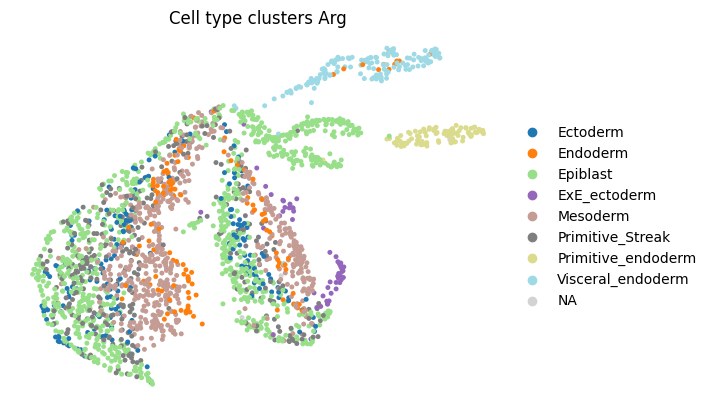

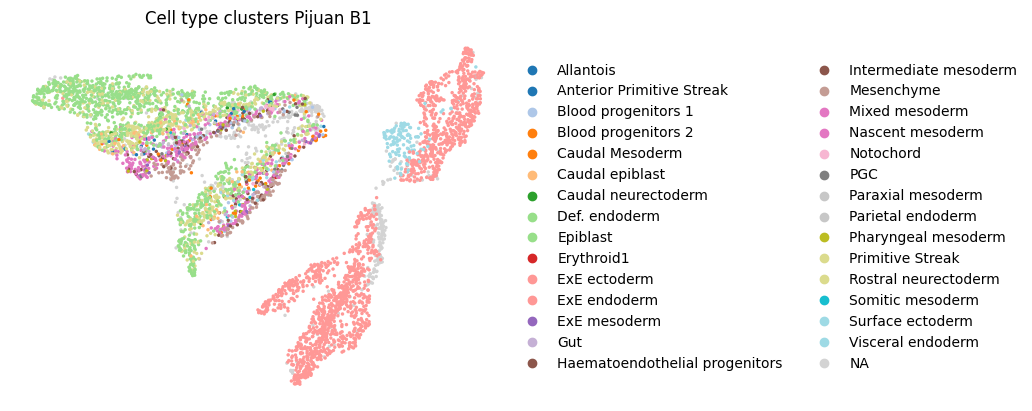

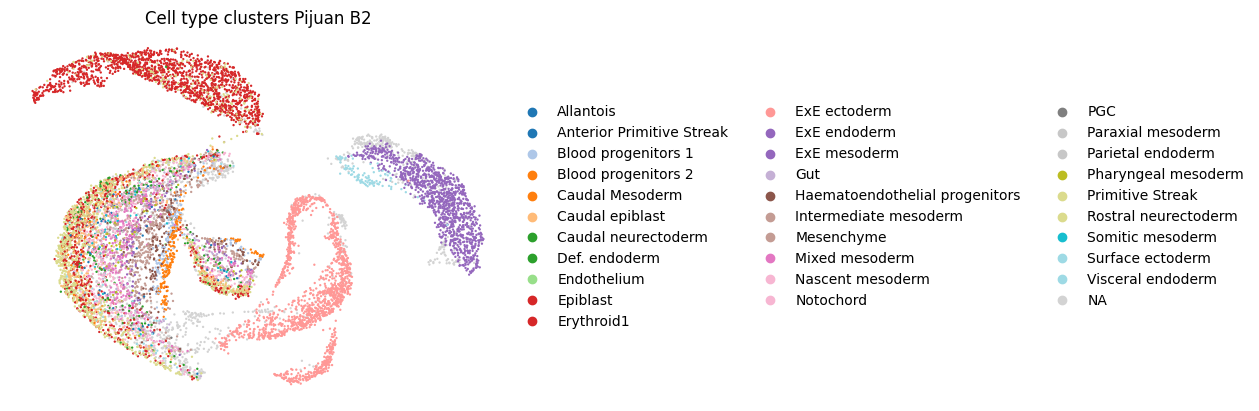

In [20]:
sc.pl.umap(
    arg_hvg,
    color='celltype',  # Pre-annotated cell labels
    frameon=False,
    title=f'Cell type clusters Arg',
    palette='tab20',
    # save=f'_celltype_{dataset_name}.pdf'
)

sc.pl.umap(
    pb1_hvg,
    color='celltype',  # Pre-annotated cell labels
    frameon=False,
    title=f'Cell type clusters Pijuan B1',
    palette='tab20',
    # save=f'_celltype_{dataset_name}.pdf')
)
sc.pl.umap(
    pb2_hvg,
    color='celltype',  # Pre-annotated cell labels
    frameon=False,
    title=f'Cell type clusters Pijuan B2',
    palette='tab20',
    # save=f'_celltype_{dataset_name}.pdf'
)

## HVG integration and Batch Alignment

In [26]:
batch_hvgs = []

batch_hvgs.append(set(arg_hvg.var_names[arg_hvg.var['highly_variable']]))
batch_hvgs.append(set(pb1_hvg.var_names[pb1_hvg.var['highly_variable']]))
batch_hvgs.append(set(pb2_hvg.var_names[pb2_hvg.var['highly_variable']]))



combined_hvgs = set.union(*batch_hvgs)

In [31]:
# # Add dataset labels
# for adata, name in zip([arg_doublet, pb1_doublet, pb2_doublet], ['arg', 'pb1', 'pb2']):
#     adata.obs['batch'] = name

# Concatenate while preserving individual PCAs
adata_combined = arg_doublet.concatenate(
    pb1_doublet, 
    pb2_doublet,
    batch_key="batch"
    
)

adata_combined.obs["celltype"] = adata_combined.obs["celltype"].astype('category')

# Ensure "Unknown" is a valid category
adata_combined.obs["celltype"] = adata_combined.obs["celltype"].cat.add_categories("Unknown")
# Replace NaNs with "Unknown" safely
adata_combined.obs["celltype"] = adata_combined.obs["celltype"].fillna("Unknown")

/tmp/ipykernel_31/802947676.py:6: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = arg_doublet.concatenate(


In [32]:
valid_genes = [gene for gene in list(combined_hvgs) if gene in adata_combined.var_names]
# print(f"Found {len(valid_genes)}/{len(list(combined_hvgs.Genes))} genes in adata_combined")
adata_combined = adata_combined[:, list(valid_genes)].copy()


## Harmony Integration to remove Batch Effects

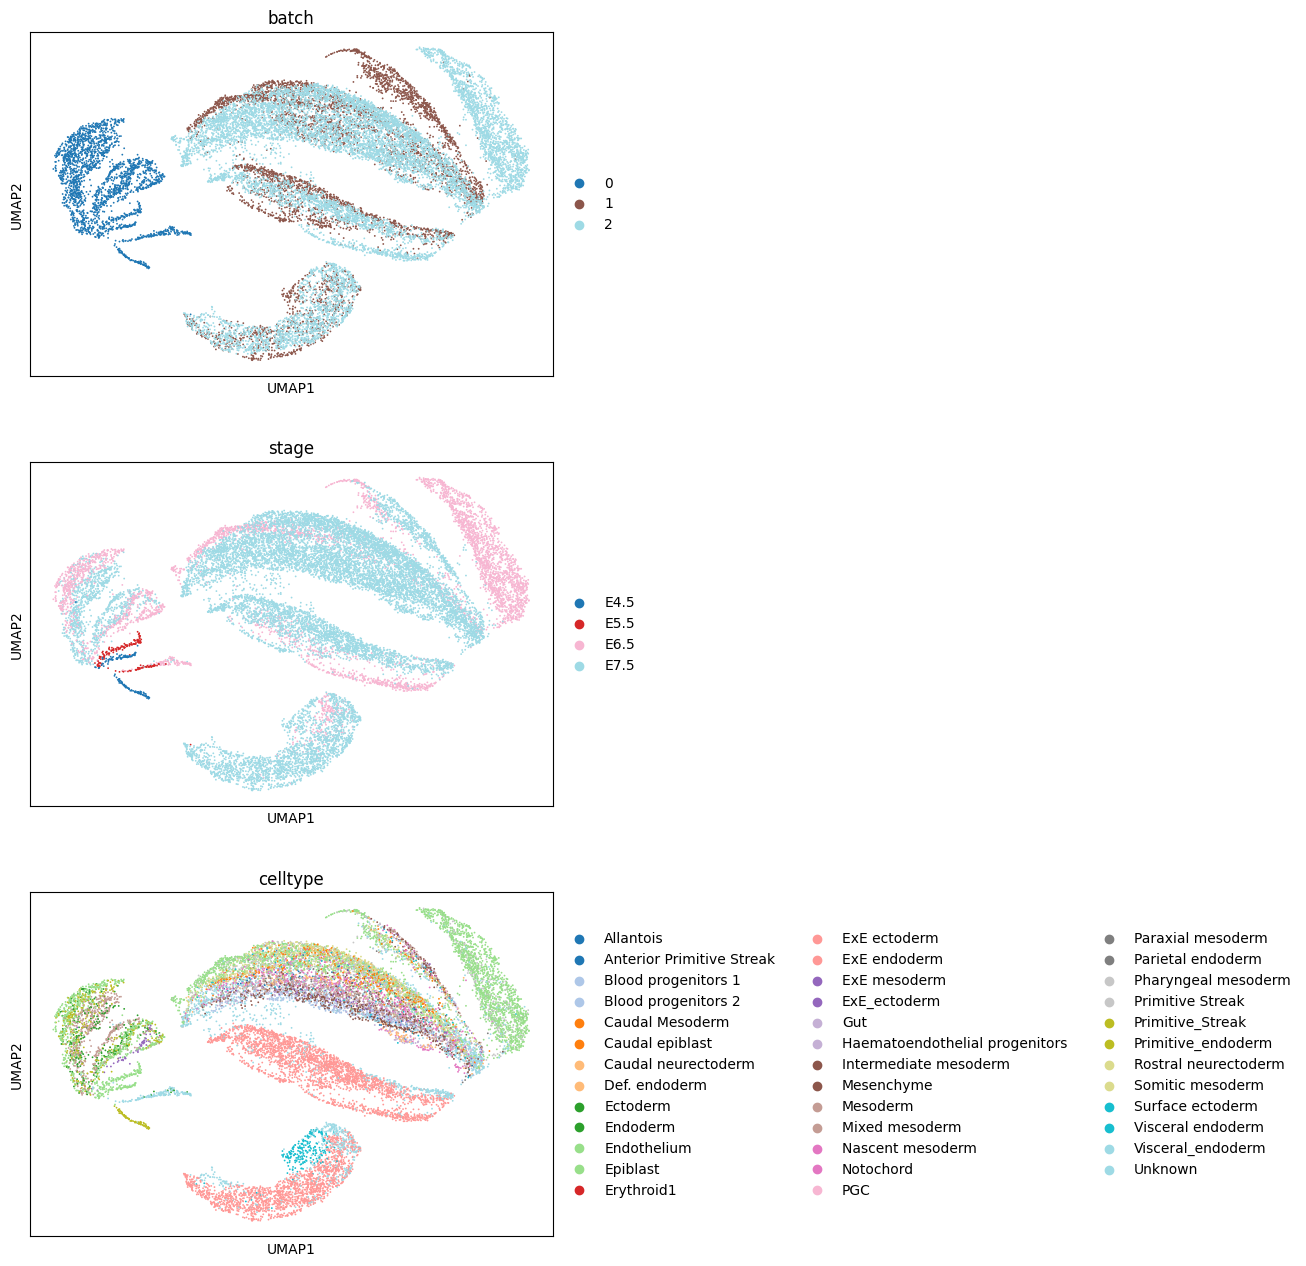

2025-04-26 14:44:22,710 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-26 14:44:25,234 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-26 14:44:25,298 - harmonypy - INFO - Iteration 1 of 10
2025-04-26 14:44:29,328 - harmonypy - INFO - Iteration 2 of 10
2025-04-26 14:44:33,333 - harmonypy - INFO - Converged after 2 iterations


In [37]:
# PCA on merged data
sc.pp.pca(adata_combined,n_comps=30,svd_solver='arpack')
sc.pp.neighbors(adata_combined)
sc.tl.umap(adata_combined)
sc.pl.umap(adata_combined,color=['batch','stage','celltype'], ncols=1)


#Harmony integration
sc.external.pp.harmony_integrate(adata_combined, key='batch')
sc.pp.neighbors(adata_combined, use_rep='X_pca_harmony',n_pcs=30)

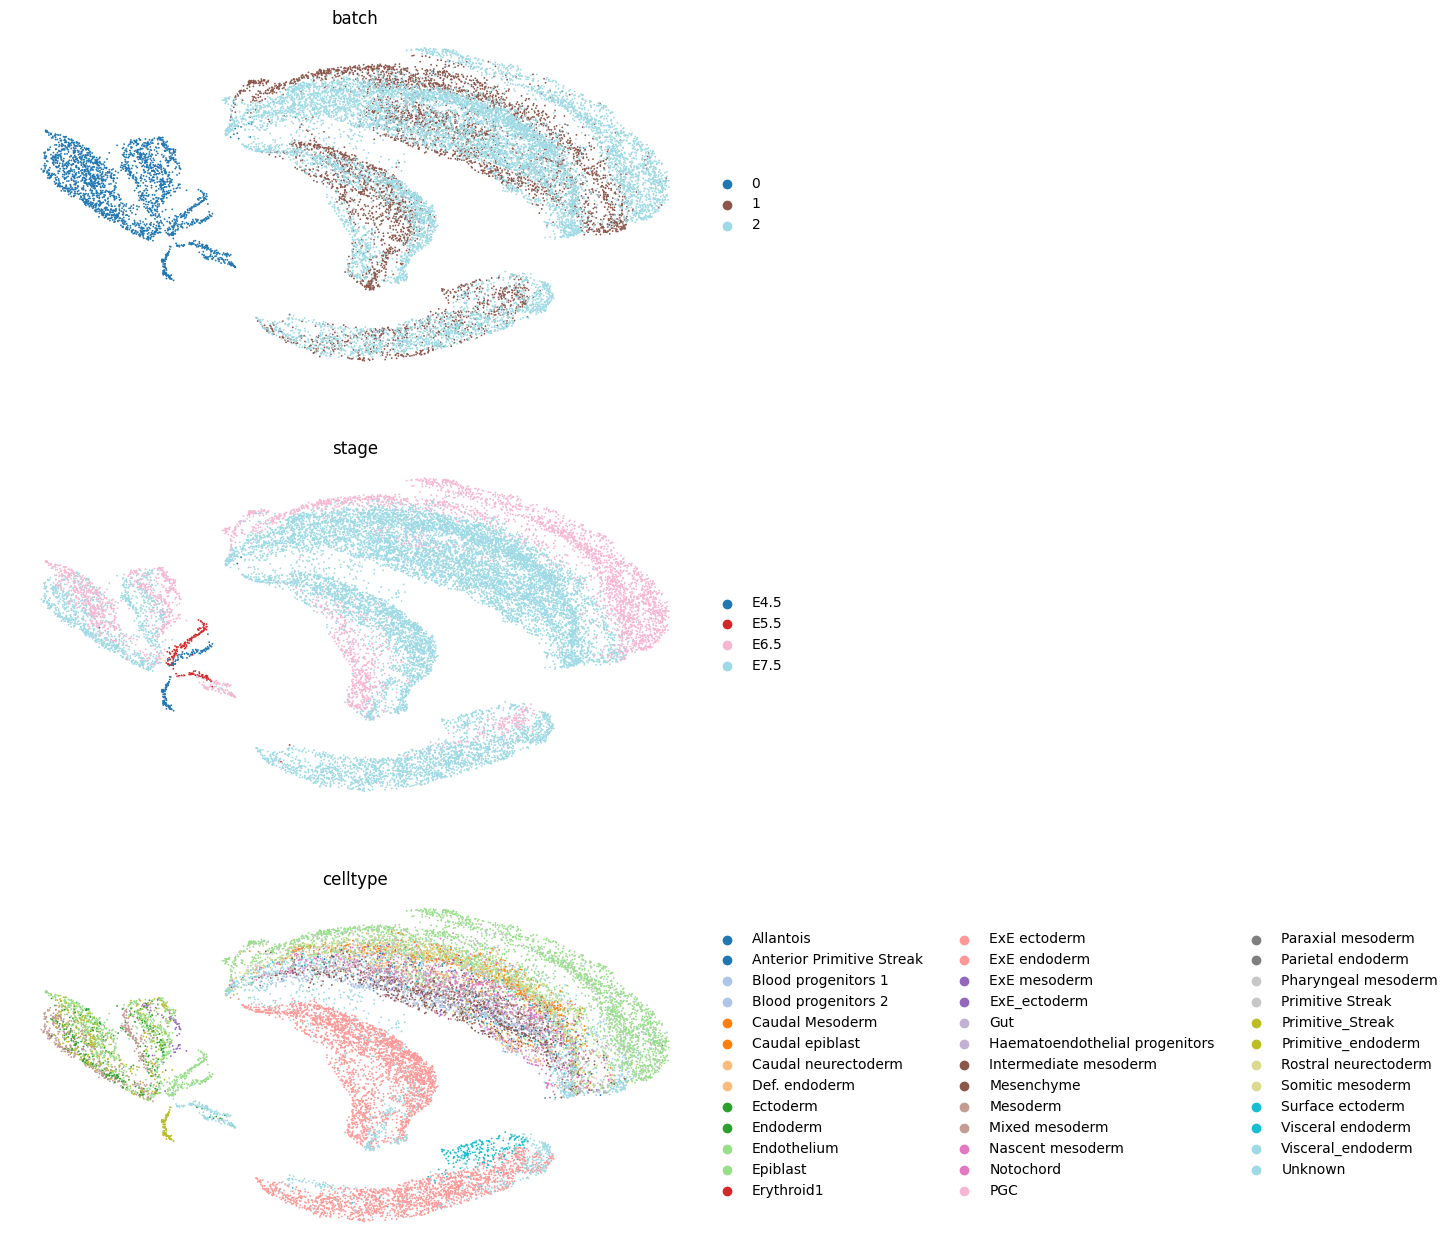

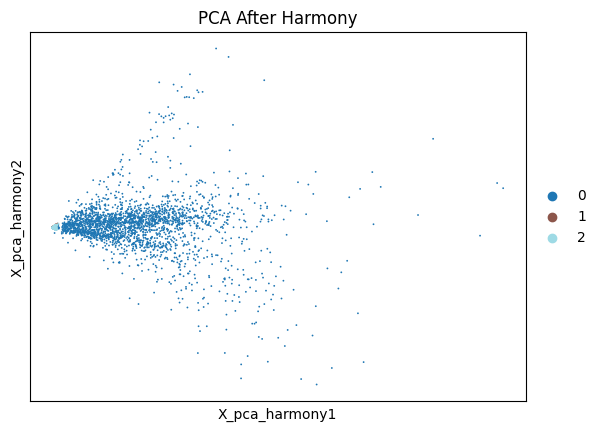

In [39]:

sc.tl.umap(adata_combined)
sc.tl.leiden(adata_combined, resolution=0.5)
# 7. Validate integration

sc.pl.umap(adata_combined, color=['batch', 'stage', 'celltype'], wspace=0.5,frameon=False,ncols=1)


# After Harmony
sc.pl.embedding(
    adata_combined, 
    basis='X_pca_harmony', 
    color='batch', 
    title='PCA After Harmony'
    
)

In [40]:
from sklearn.metrics import silhouette_score

# Biological vs. technical separation
celltype_score = silhouette_score(
    adata_combined.obsm['X_pca_harmony'], 
    adata_combined.obs['celltype']
)
batch_score = silhouette_score(
    adata_combined.obsm['X_pca_harmony'],
    adata_combined.obs['batch']
)

print(f"Cell type silhouette: {celltype_score:.2f} (ideal >0.5)")
print(f"Batch silhouette: {batch_score:.2f} (ideal <0.1)")

Cell type silhouette: -0.37 (ideal >0.5)
Batch silhouette: 0.01 (ideal <0.1)
